In [29]:
import os
import sys
sys.path.insert(0,'./tools/')

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['contour.negative_linestyle']= 'solid'
import cmocean

In [24]:
# Get properties and functions specific to S-MODE maps
from tools.config import MAPEXTENT
from maps import *

In [25]:
# Get slice of ETOPO1 topography data from WHOI's GEOPORT thredds server
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bathy = xr.open_dataset(url)
bathy = bathy.sel(lon=slice(MAPEXTENT[0],MAPEXTENT[1]),
                  lat=slice(MAPEXTENT[2],MAPEXTENT[3])
)

### Plot a simple map of the operations area using cartopy

In [26]:
# Set figure settings
figdir  = 'img/'
filename = 'SMODE_OperationsArea'
extension = ['png','pdf']
figproperties = dict(dpi=200,bbox_inches='tight')

In [27]:
projection = ccrs.PlateCarree(central_longitude=(MAPEXTENT[0]+MAPEXTENT[1])/2)

[None, None]

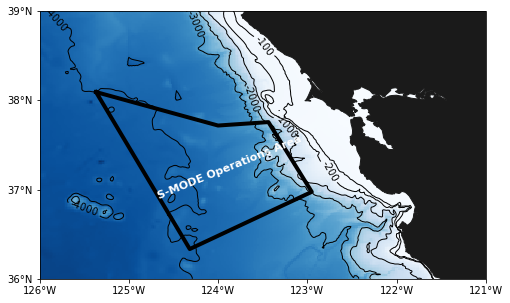

In [28]:
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111, projection=projection)     

ax.set_extent(MAPEXTENT)

# Topography
plot_topography(ax, colors=True,
                transform=ccrs.PlateCarree()
)

# Map properties (continent, labels, grid)
plot_map_properties(ax,transform=ccrs.PlateCarree())

# SMODE area
plot_operations_area(ax=ax,
                     transform=ccrs.PlateCarree(),
                     add_label=True
)

# Save figure in the desired extensions
[fig.savefig(os.path.join(figdir,filename+'_cartopy.'+ext),
             **figproperties) 
             for ext in extension]